# Initial stuff

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
import docker, random, time, subprocess


In [2]:
def generate_docker_compose(index, neighbors, path):
    # Define the Docker Compose template
    template = f"""  node-{index}:
    image: my_image
    networks:
      - net
    environment:
      NEIGHBORS_LIST: '{neighbors}'
      QUEUE: 'queue-{index}'
    container_name: node-{index}
"""
    # Write the Docker Compose file
    with open(path, "a") as file:
        file.write(template)
      
def transform_element(elemento):
    return f"queue-{elemento}"

def transform_list(elemento):
    elemento = list(map(lambda x: transform_element(x), elemento))
    return ",".join(elemento)

In [9]:
# Docker-compose file location
path = "C:/Users/paolo/Documents/Università/Dependable Distribuited Systems/Progetto/the-price-of-validity"

# Hosts
hosts = 10

# Define the power-law exponent
gamma = 2.9

# Create Topology
Choose between topologies

## Random Topology

In [4]:
neighbors = [[] for _ in range(hosts)]
# Calcola il numero totale di collegamenti che dovrebbero essere presenti per avere un grado medio di 5
num_total_links = hosts * 5

avg_links = 0

while avg_links != 5:
    # Distribuzione casuale per il numero di collegamenti di ogni nodo
    num_links_per_host = [random.randint(0, 9) for _ in range(hosts)]

    links = 0
    for col in num_links_per_host:
        links += col
    avg_links = links / hosts
    print(f'Average links {avg_links}')

# Costruisci i collegamenti dei nodi
for host in range(hosts):
    num_links = num_links_per_host[host]
    
    while len(neighbors[host]) < num_links and num_total_links > 0:
        dest_host = random.randint(0, hosts-1)
        
        # Verifica che il collegamento non esista già e che il host non si colleghi a se stesso
        if dest_host not in neighbors[host] and host != dest_host:
            neighbors[host].append(dest_host)
            neighbors[dest_host].append(host)
            num_total_links -= 2

neighbors_flatten = list(map(lambda x: transform_list(x), neighbors))

Average links 3.4
Average links 4.8
Average links 3.5
Average links 4.3
Average links 5.4
Average links 4.3
Average links 4.3
Average links 4.2
Average links 4.5
Average links 5.0


## Powerlaw Topology

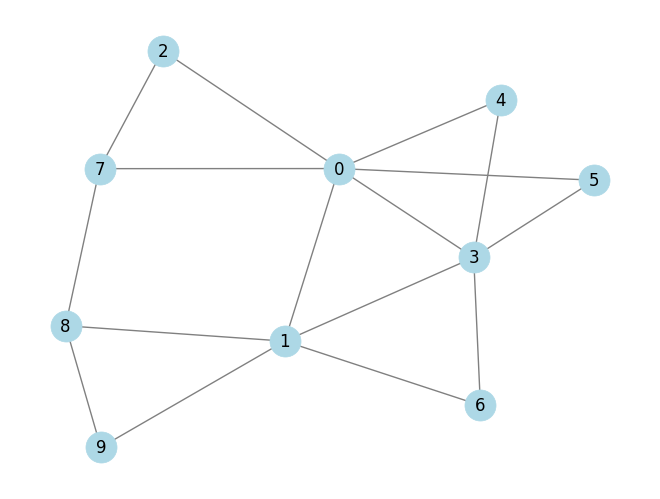

In [10]:
# Create the Barabasi-Albert network => approssimazione della power-law network
# barabasi_albert_graph function to generate a Barabasi-Albert network with
# thespecified number of hosts (hosts) and an integer value for the
# average degree, which is derived from the power-law exponent (gamma).
# Note that the average degree is rounded down to the nearest integer. per questo da 2.9 a 3
network = nx.barabasi_albert_graph(hosts, int(gamma))

# Print the network summary
nx.draw(network, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray', linewidths=0.5)
plt.savefig(path+'/powerlaw_graph.pdf')

neighbors = []
for i in network.nodes:
  currneigh = []
  for j in network.neighbors(i):
    currneigh.append(j)
  neighbors.append(currneigh)

neighbors_flatten = list(map(lambda x: transform_list(x), neighbors))

# Generate docker-compose file

In [11]:
file = open(path+'/docker-compose.yml', 'w')
template = f"""version: "3"
services:
"""
file.write(template)
file.close()

# Stampa la lista dei vicini di ogni nodo
for i, lista in enumerate(neighbors_flatten):
    print(f"Vicini del host {i}: {lista}")
    generate_docker_compose(i, lista, path+'/docker-compose.yml')

template = f"""networks:
  net:
    driver: bridge
"""
# Write the Docker Compose file
with open(path+'/docker-compose.yml', 'a') as file:
    file.write(template)

Vicini del host 0: queue-1,queue-2,queue-3,queue-4,queue-5,queue-7
Vicini del host 1: queue-0,queue-3,queue-6,queue-8,queue-9
Vicini del host 2: queue-0,queue-7
Vicini del host 3: queue-0,queue-1,queue-4,queue-5,queue-6
Vicini del host 4: queue-0,queue-3
Vicini del host 5: queue-0,queue-3
Vicini del host 6: queue-1,queue-3
Vicini del host 7: queue-0,queue-2,queue-8
Vicini del host 8: queue-1,queue-7,queue-9
Vicini del host 9: queue-8,queue-1


# Docker Compose Up

In [20]:
command = "docker build -t my_image ."
result = subprocess.run(command, shell=True, capture_output=True, text=True)
print(result.stderr)

command = "docker compose -p nodes up -d"
result = subprocess.run(command, shell=True, capture_output=True, text=True)
print(result.stderr)

#1 [internal] load .dockerignore
#1 transferring context: 2B done
#1 DONE 0.0s

#2 [internal] load build definition from Dockerfile
#2 transferring dockerfile: 406B done
#2 DONE 0.0s

#3 [internal] load metadata for docker.io/library/python:3.8-slim-buster
#3 DONE 0.6s

#4 [1/4] FROM docker.io/library/python:3.8-slim-buster@sha256:8799b0564103a9f36cfb8a8e1c562e11a9a6f2e3bb214e2adc23982b36a04511
#4 DONE 0.0s

#5 [internal] load build context
#5 transferring context: 104B done
#5 DONE 0.0s

#6 [2/4] WORKDIR /app
#6 CACHED

#7 [3/4] RUN pip3 install pika
#7 CACHED

#8 [4/4] COPY /docker .
#8 CACHED

#9 exporting to image
#9 exporting layers done
#9 writing image sha256:93131c72fe0aae24d9fb6fc3aa1dd7e1f1e0660654bbc5794d610b16cab840d5 done
#9 naming to docker.io/library/my_image 0.0s done
#9 DONE 0.0s

 Network nodes_net  Creating
 Network nodes_net  Created
 Container node-9  Creating
 Container node-8  Creating
 Container node-5  Creating
 Container node-2  Creating
 Container node-4  Cre

# Start Query

# Stop Container

In [ ]:
def stop_container(container_name, seconds):
    client = docker.from_env()
    
    time.sleep(seconds)

    try:
        container = client.containers.get(container_name)
        container.stop()
        print(f"Container '{container_name}' stopped successfully.")
        
    except docker.errors.NotFound:
        print(f"Container '{container_name}' not found.")
        
    except docker.errors.APIError as e:
        print(f"An error occurred while stopping container '{container_name}': {e}") 
    
    # try:
    #     container = client.containers.get(container_name)
    #     container.start()
    #     print(f"Container '{container_name}' started successfully.")
        
    # except docker.errors.NotFound:
    #     print(f"Container '{container_name}' not found.")
        
    # except docker.errors.APIError as e:
    #     print(f"An error occurred while starting container '{container_name}': {e}")

# Esempio di utilizzo
container_name = "node-8"
seconds = 10

stop_container(container_name, seconds)